In [4]:
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
from surprise import Dataset
#from surprise.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import copy 
%matplotlib inline

# Course reminder

Matrix factorisation consists in expressing one matrix as the product of two smaller matrices. The idea is to have a lower rank approximation of the original matrix. This lower rank approximation relies on an approximation of the latent factors and thus offers an insight on the problem.

Applications include signal decomposition, where a matrix of signals is decomposed into a set of base components along with a mixing matrix. In recommender systems, considering a matrix of user ratings for movies, matrix factorisation infers the latent characteristics of the movies and the affinity of users for each of them.

Given a matrix $\mathbf{R} \in \mathbb{R}^{n \times m}$, we want to find the matrices $\mathbf{P} \in \mathbb{R}^{n \times k}$ and $\mathbf{Q} \in \mathbb{R}^{m \times k}$ such as
$$\hat{\mathbf{R}} = \mathbf{P} \cdot \mathbf{Q}^\top \approx \mathbf{R}$$


# Exercice 1 - The gradient descent

The simplest way to compute the matrices $\mathbf{P}$ and $\mathbf{Q}$ is to use a gradient descent. It consists in initializing the estimated matrices randomly, compute their difference to the real data, and follow the gradient of the values to reach a minimum.

I this exercise, we will consider a divergence based on the Euclidean distance: the Frobenius norm:

$$\min_{\mathbf{P}, \mathbf{Q} > 0} \| \mathbf{R} - \mathbf{P} \cdot \mathbf{Q}^\top\|^2_F$$


## The Squared Error

The goal here is to minimize the reconstruction error. The first step is to compute this error. Write below a function that computes the formula for this error given $\mathbf{R}$, $\mathbf{P}$, $\mathbf{Q}$ and two indices $i$ and $j$:

In [2]:
def error(R, P, Qt):
    return np.linalg.norm(R - P @ Qt)**2

## Deriving the update function for $\mathbf{P}$

Now that we have the error, we need to minimize it with regard to $\mathbf{P}$. First, derive the formula above, with regard to $\mathbf{P}$. Then, write, the update function for $\mathbf{P}$. We call $\alpha$ the parameter related to the gradient descent update.

In [3]:
# ∥XW - Y∥
# 2(XW - Y) W.T

In [28]:
def update_P(R, P, Qt, alpha):
    P += alpha *  2 * (R - P @ Qt) @ Qt.T # Differentielle
    return P

## Deriving the update function for $\mathbf{Q}$

Do the same for $\mathbf{Q}$. Both matrices being symmetrical in the formulation of the problem, it boils down to replacing swapping $\mathbf{P}$ by $\mathbf{Q}$.

In [29]:
def update_Q(R, P, Qt, alpha):
    Q = Qt.T
    Q += alpha * 2 * (R - P @ Qt).T @ P
    return Q

## Iterating

Now that the update functions are coded, all that remains is to iterate and stop at a given criterion. The best is to go for the common methods: having a limited number of steps and a tolerance depending on the value of the error.

In [24]:
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, es=None):
    # do something
    for k in range(steps):
        Q = update_Q(R, P, Q.T, alpha)
        np.clip(Q, a_min=0, a_max=None)
        P = update_P(R, P, Q.T, alpha)
        np.clip(P, a_min=0, a_max=None)
        if es is not None:
            es.append(error(R,P,Q.T))
        #print(str(k)+'\r', end='')
        
    return P, Q

## Simple example

For sanity check, let us tun this algorithm on a toy matrix.

In [27]:
R = [
     [5,3,0,1],
     [4,0,0,1],
     [1,1,0,5],
     [1,0,0,4],
     [0,1,5,4],
    ]
 
R = np.array(R)
 
N = len(R)
M = len(R[0])
K = 2
 
P = np.random.rand(N,K)
Q = np.random.rand(M,K)

es = []
nP, nQ = matrix_factorization(R, P, Q, K, steps=10000, alpha=0.0001, es=es)
nR = np.dot(nP, nQ.T)

print(R)
print(nR)
print("Miam!")

NameError: name 'update_Q' is not defined

## Debugging
Debugging machine learning algorithms is most of the time tedious. For this algorithm, we have one guarantee: The global loss should decrease at each iteration. One good reflex is to log this information (if you code a ML API for somebody else, providing that kind of feature will be greatly appreciated). There are two common ways to provide this information. The first one is to add a verbose mode and print the loss. A graph can then be crafted using grep. The second option, in particular for Python, is to provide a list as an option. If the list is present, it will be fed with the value of the loss at each iteration. Implement the latter and display below the plot of the loss.

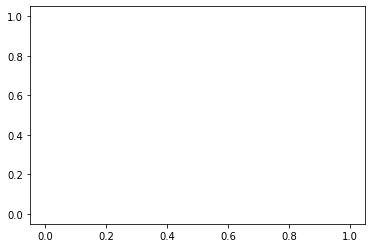

In [26]:
plt.plot(es)

## Comparison with an existing implementation
Scikit-learn is a very famous ML package for Python. They do provide an implementation of the NMF algorithm. Compare your implementation to theirs.

In [9]:
from sklearn.decomposition import NMF


nmf = NMF(n_components=2)
W = nmf.fit_transform(R)
H = nmf.components_
print(np.dot(W, H))
print(error(R,W,H))

[[5.2558264  1.99313836 0.         1.45512772]
 [3.50429478 1.32891458 0.         0.9701988 ]
 [1.31294288 0.94415991 1.94956896 3.94609389]
 [0.98129195 0.72179987 1.52759811 3.0788454 ]
 [0.         0.65008935 2.84003662 5.21894555]]
18.28870740178847


# Adding regularization
If you run the script several times, you may notice that the reconstruction is good but the matrices $\mathbf{P}$ and $\mathbf{Q}$ change a lot. A way to fix this problem is to inject more information in the model. It is most of the time done under the the form of a regularization.

The regularization is a term added to the loss that add a constraint on the resulting matrices. The constraint must be adapted to the needs. In the following, we use NMF for the purpose of topic extraction.

In the following, we want to add an L1 and L2 regularizers to the previous algorithm.

A famous application, in particular for L1 norm is the processing of text information. In the following example, we want to extract the topics out of a corpus of documents. The first step is compute the tf-idf measure for each word.

In [32]:
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

# Get all unique words
words = [words for doc in documents for words in doc]
words = np.unique(words)

# Create a matrix for tfidf values
tfidf = np.zeros((len(documents), len(words)))

# For each term, compute its idf
idfs = []
for word in words:
    count = np.sum([word in doc for doc in documents])
    idfs.append(np.log(len(documents) / count))
    
# Now fill the tfidf matrix
for iw, word, idf in zip(range(len(words)), words, idfs):
    for id, doc in enumerate(documents):
        tfidf[id, iw] = np.sum(np.asarray(doc) == word) / len(doc) * idf
        
R = tfidf
print(R)

[[0.2299197  0.         0.28784329 0.2299197  0.28784329 0.
  0.2299197  0.         0.         0.         0.         0.
  0.         0.         0.         0.38686431 0.38686431 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.4029806  0.32188758 0.         0.
  0.         0.         0.         0.4029806  0.         0.54161004
  0.4029806  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.22029264 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0

Now that we have a matrix of data, we can use it with our previous algorithm.

In [35]:
N = len(R)
M = len(R[0])
K = 4

np.random.seed(seed=0)
P = np.random.rand(N,K)
Q = np.random.rand(M,K)

print(Q.T)

nP, nQ = matrix_factorization(R, P, Q, K, steps=20000, alpha=0.0001)
nR = np.dot(nP, nQ.T)

[[0.15896958 0.19658236 0.83794491 0.97676109 0.28280696 0.31798318
  0.56660145 0.5759465  0.13179786 0.58651293 0.67781654 0.24875314
  0.22308163 0.69947928 0.8811032  0.72525428 0.42385505 0.66017354
  0.13547406 0.57432525 0.8965466  0.80619399 0.7142413  0.16249293
  0.80731896 0.69742877 0.97552151 0.72999056 0.19999652 0.34535168
  0.16469416 0.934214   0.73012203 0.18619301 0.22741463 0.31179588]
 [0.11037514 0.36872517 0.09609841 0.60484552 0.12019656 0.41426299
  0.26538949 0.9292962  0.7163272  0.02010755 0.27000797 0.57615733
  0.95274901 0.29743695 0.58127287 0.50132438 0.60639321 0.29007761
  0.29828233 0.65320082 0.36756187 0.70388858 0.99884701 0.61555956
  0.56910074 0.45354268 0.85580334 0.17162968 0.01852179 0.92808129
  0.6214784  0.61396596 0.311945   0.94437239 0.25435648 0.69634349]
 [0.65632959 0.82099323 0.97645947 0.73926358 0.2961402  0.0641475
  0.52324805 0.31856895 0.28940609 0.82894003 0.73519402 0.59204193
  0.44712538 0.81379782 0.88173536 0.95608363 0

The $\mathbf{Q}$ matrix contains, for each word, a score indicating its affinity with each topic. A first sanity check for this algorithm is to look at the 5 top words for each topic.

Print them under the following pattern:

Topic 1: Hadoop, C++, Python, R, NoSQL

Topic 2: ...

In [36]:
words_indexes=np.argsort(nQ.T)
print(words[words_indexes][:,:5]) #5 most relevant word-topics sorted
sns.set(color_codes=True)


[['MapReduce' 'Hadoop' 'theory' 'mathematics' 'decision trees']
 ['MongoDB' 'databases' 'MySQL' 'programming languages' 'Postgres']
 ['support vector machines' 'libsvm' 'Mahout' 'machine learning'
  'neural networks']
 ['statsmodels' 'statistics' 'MapReduce' 'Hadoop' 'R']]


[[ 0.97690251  0.87221899  0.71007345  0.70263239  0.67467628  0.66626642
   0.56485341  0.56239388  0.5617364   0.52906125  0.49893396  0.4705851
   0.46624589  0.44716906  0.42472948  0.39740181  0.39559381  0.36655236
   0.36546023  0.36041254  0.35406773  0.34853778  0.30234458  0.28803935
   0.28275611  0.27120184  0.25918978  0.25562619  0.24544222  0.21124598
   0.19681584  0.17901205  0.16084852  0.13644885  0.04334277  0.00183202]
 [ 0.89308659  0.84851466  0.8391316   0.66619236  0.64654048  0.64418157
   0.63721015  0.60000012  0.49077345  0.48151842  0.47470013  0.46282917
   0.42319502  0.41835004  0.41248413  0.38309483  0.36911445  0.34642966
   0.32755772  0.28218502  0.24491289  0.20004771  0.18269791  0.16773189
   0.16465432  0.15171584  0.15119502  0.15087396  0.14104738  0.13587313
   0.12930448  0.11653032  0.09608206  0.02837066 -0.0314356  -0.0634607 ]
 [ 0.82929155  0.80841646  0.80002685  0.7206556   0.70365279  0.68715145
   0.68700511  0.590181    0.57395569

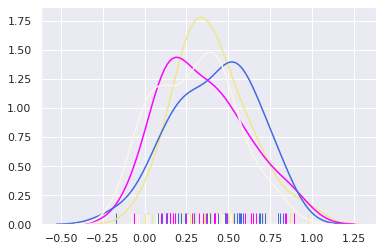

In [37]:
#Relancer à volonté cette cellule pour redécouvrir sa beauté saisisante.
colors=np.array(list(matplotlib.colors.cnames.keys()))
np.random.shuffle(colors)
for dist,color in zip(nQ.T, colors):
    sns.distplot(dist, color=color, hist=False, rug=True)

sortedQn = np.sort(nQ.T, axis=1)[:,::-1]
print(sortedQn)

array([0.20518664, 0.23577845, 0.24458101, 0.21017409])

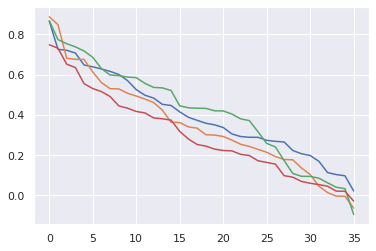

In [14]:
for x in sortedQn:
    sns.lineplot(data=x)
np.std(nQ.T, axis=1)

Another interesting graph to look at is the matrix of weights in Q. We expect each line of $\mathbf{Q}^\top$ (or topic) to contain strongly differentiated values to indicate that the topics are well segmented. Is this the case?

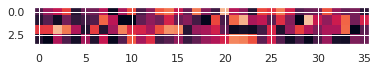

In [15]:
plt.imshow(nQ.T, vmin=0, vmax=1)

## Adding an L2 penalization
Usually, the l2 penalization is applied on both matrices $\mathbf{P}$ and $\mathbf{Q}$. The elements that must be updated are:
* the loss
* the update of $\mathbf{P}$ matrix
* the update of $\mathbf{Q}$ matrix

You can copy paste all the function in the cell below to make it more practical.

In [6]:
def error_l2(R, P, Qt, beta):
    return np.linalg.norm(R - P @ Qt)**2 + beta*np.linalg.norm(P) + beta*np.linalg.norm(Qt)

def update_P_l2(R, P, Qt, alpha, beta):
    P += alpha *  (2 * (R - P @ Qt) @ Qt.T - 2*beta*P) # Differentielle
    return P
  
def update_Q_l2(R, P, Qt, alpha, beta):
    Q = Qt.T
    Q += alpha * (2 * (R - P @ Qt).T @ P - 2*beta*Q)
    return Q
        
def matrix_factorization_l2(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02, es=None):
    for k in range(steps):
        Q = update_Q_l2(R, P, Q.T, alpha, beta)
        np.clip(Q, a_min=0, a_max=None)
        P = update_P_l2(R, P, Q.T, alpha, beta)
        np.clip(P, a_min=0, a_max=None)
        if es is not None:
            es.append(error_l2(R,P,Q.T, beta))
    return P, Q

In [7]:
es = []
nP, nQ = matrix_factorization_l2(R, P, Q, K, steps=10000, alpha=0.0002, beta=0.05, es=es)
nR = np.dot(nP, nQ.T)

plt.plot(es)
#On voit l'effet de L2

NameError: name 'R' is not defined

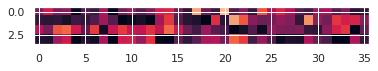

In [18]:
plt.imshow(nQ.T, vmin=0, vmax=1)

## Adding L1 penalization
Repeat the steps above for the l1 penalization.

In [19]:
def error_l1(R, P, Qt, beta):
    return np.linalg.norm(R - P @ Qt)**2 + beta* LA.norm(P, 1) + beta*LA.norm(Qt, 1)

def update_P_l1(R, P, Qt, alpha, beta):
    P += alpha *  (2 * (R - P @ Qt) @ Qt.T - beta) # Differentielle
    return P
  
def update_Q_l1(R, P, Qt, alpha, beta):
    Q = Qt.T
    Q += alpha * (2 * (R - P @ Qt).T @ P - beta)
    return Q
        
def matrix_factorization_l1(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02, es=es):
    for k in range(steps):
        Q = update_Q_l1(R, P, Q.T, alpha, beta)
        np.clip(Q, a_min=0, a_max=None)
        P = update_P_l1(R, P, Q.T, alpha, beta)
        np.clip(P, a_min=0, a_max=None)
        if es is not None:
            es.append(error_l1(R,P,Q.T, beta))
    return P, Q

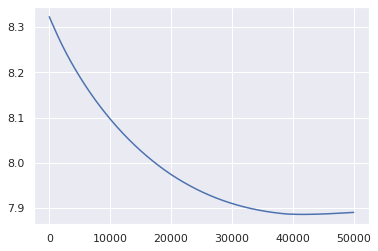

In [20]:
es = []
nP, nQ = matrix_factorization_l1(R, P, Q, K, steps=50000, alpha=0.0001, beta=0.05, es=es)
nR = np.dot(nP, nQ.T)
plt.plot(es)

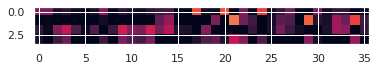

In [21]:
plt.imshow(nQ.T, vmin=0, vmax=1)
# C'est SPARSE !

# Recommender systems
The goal of a recommender system is simple: Given a matrix of user/item ratings, infer the rating that would give a user to a given item using the existing ratings.

For once, we are being lucky with this problem in NMF, because the  inference comes for free with most algorithms. It boils down to simply putting 0 in the matrix where the data is missing and *not* performing any optimization on these values.

In [8]:
def error_l1_l2(R, P, Qt, beta, gamma):
    return (np.linalg.norm(R - P @ Qt)**2 + 
            beta*LA.norm(P, 1) + beta*LA.norm(Qt, 1) + 
            gamma*np.linalg.norm(P) + gamma*np.linalg.norm(Qt))

def update_P_l1_l2(R, P, Qt, alpha, beta, gamma):
    P += alpha *  (2 * (R - P @ Qt) @ Qt.T - beta - 2*gamma*P) # Differentielle
    return P
  
def update_Q_l1_l2(R, P, Qt, alpha, beta, gamma):
    Q = Qt.T
    Q += alpha * (2 * (R - P @ Qt).T @ P - beta - 2 * gamma*Q)
    return Q
        
def matrix_factorization_l1_l2(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.03, gamma=0.02, es=es):
    for k in range(steps):
        Q = update_Q_l1_l2(R, P, Q.T, alpha, beta, gamma)
        np.clip(Q, a_min=0, a_max=None)
        P = update_P_l1_l2(R, P, Q.T, alpha, beta, gamma)
        np.clip(P, a_min=0, a_max=None)
        if es is not None:
            es.append(error_l1_l2(R,P,Q.T, beta, gamma))
    return P, Q

The example belows shows a matrix where the inferred ratings should be obvious.

[[4.8  5.6  4.   0.  ]
 [5.3  2.1  5.5  1.5 ]
 [3.05 3.85 1.25 6.25]
 [3.55 3.35 1.75 5.75]
 [1.3  3.1  5.5  4.5 ]]
[[4.73901064 3.85362388 5.25560169 0.52305861]
 [4.53273775 3.80672161 4.95634183 1.07566186]
 [2.5315562  3.35169367 2.05303578 6.43681029]
 [2.76803415 3.40546394 2.39611703 5.80328787]
 [3.39341729 3.54766332 3.30342036 4.12789166]]


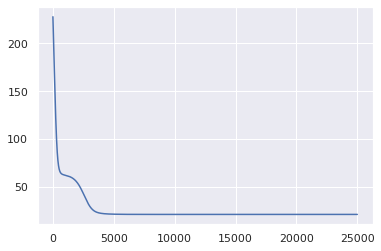

In [66]:
R = [
     [5,5,5,1],
     [4,0,5,1],
     [1,1,0,5],
     [1,0,0,4],
     [0,1,5,4],
    ]
 
R = np.array(R)
R = user_items_biais(R)

N = len(R)
M = len(R[0])
K = 2
 
P = np.random.rand(N,K)
Q = np.random.rand(M,K)
es=[]
nP, nQ = matrix_factorization_l1_l2(R, P, Q, K, steps=25000, alpha=0.0001, beta=0.03, gamma=0.02, es=es)
nR = np.dot(nP, nQ.T)

plt.plot(es)

print(R)
print(nR)

## Introducing user and item bias
When dealing with recommender systems, each user may have its own bias. A movie can also be biased byt the communication around it. In this kind of method, a bias is represented as a constant corresponding to each user and each movie.

Modifiy the current system to integrate user and movie bias in your optimization.

In [64]:
# Ri,j = bu[i] + bi[j] + SUM(k=1 to n) P[i][k]*Q[k][j]

def user_items_biais(R):
    #print(R)
    items_biais = R.mean(axis=0)
    #print(items_biais)
    users_biais = R.mean(axis=1)
    #print(users_biais)
    R = np.apply_along_axis(lambda users : users - users_biais, 0, R)
    R = np.apply_along_axis(lambda items : items - items_biais, 1, R)
    #print(R)
    return R+abs(np.min(R))


## Practical application
Now that your matrix factoriazation system is ready, embed it in a sklearn estimator and apply it on the MovieLens 100k using the previous notebook.

In [9]:
from sklearn.base import BaseEstimator

class Recommendation(BaseEstimator):
    components_ = (None, None)
    def __init__(self):
        return
    def fit(self, R):
        return self
    def fit_transform(self, R, K, steps=500, alpha=0.0002, beta=0.03, gamma=0.02, es=es):
        N = len(R)
        M = len(R[0])
        P = np.random.rand(N,K)
        Q = np.random.rand(M,K)
        nP, nQ = matrix_factorization_l1_l2(R, P, Q, K, steps=steps, alpha=alpha, beta=beta, gamma=gamma, es=es)
        components_= (nP, nQ)
        return nP @ nQ.T

(943, 1682)
Miam !


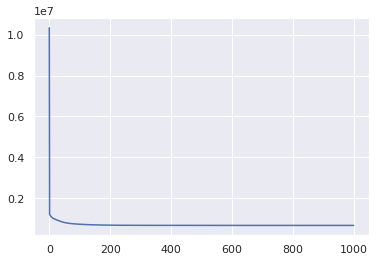

In [67]:
ml100k = Dataset.load_builtin('ml-100k')
pandas_ml100k = pd.DataFrame(ml100k.raw_ratings, 
                             columns =['userid', 'movieid', 'rates', 'timestamps'])
#Chianlit
pandas_ml100k["userid"] = pd.to_numeric(pandas_ml100k["userid"])
pandas_ml100k["movieid"] = pd.to_numeric(pandas_ml100k["movieid"])
pandas_ml100k["rates"] = pd.to_numeric(pandas_ml100k["rates"])
pandas_ml100k = pandas_ml100k.sort_values(["userid", "movieid"])

def reverse_mapping(mapping):
    reverse_mapping = np.zeros((np.max(mapping) + 1,), dtype=int)
    reverse_mapping[mapping] = np.arange(0, mapping.size)
    return reverse_mapping

userid_index = pandas_ml100k["userid"].unique().astype(dtype=int)
index_userid = reverse_mapping(userid_index)
filmid_index = pandas_ml100k["movieid"].unique().astype(dtype=int)
index_filmid = reverse_mapping(filmid_index)
nb_distinct_film = np.unique(filmid_index).size

def user_rattings(serie):
    user_rattings = np.zeros(nb_distinct_film)
    np.put(user_rattings, index_filmid[serie.movieid], serie.rates)
    return user_rattings

pandas_ml100k = pandas_ml100k.groupby("userid").agg(pd.Series.tolist).apply(user_rattings, axis=1)

users_rattings = np.hstack(pandas_ml100k.to_numpy()).reshape((-1,nb_distinct_film))
R = user_items_biais(users_rattings)
#R , R_test = train_test_split(users_rattings, shuffle=True, test_size=0.33)

print(users_rattings.shape)
K = 19 #18 genres de films selon wikipédia, 19 selon le readme de movie lens.

es=[]
recommendation = Recommendation()
nR = recommendation.fit_transform(R=users_rattings, K=K, steps=1000, alpha=0.0002, beta=0.03, gamma=0.02, es=es)

plt.plot(es)
print("Miam !")

iteration 0


/home/mados/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in matmul
  import sys
/home/mados/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in add
  import sys
/home/mados/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in matmul
  if sys.path[0] == '':
/home/mados/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in add
  if sys.path[0] == '':


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9


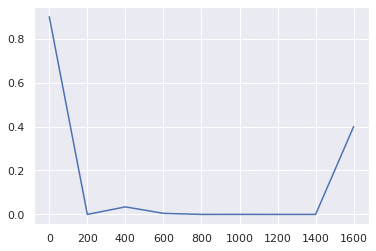

In [68]:
#A quel point la perte d'information impacte nmf ?

def random_index(holes_nb):
    return np.random.choice(np.arange(len(R[1])),  holes_nb, replace=False)

holes_nbs =  list(range(0, len(R[1]),200))
itera = 10
means_res = None
for k in range(itera):
    print("iteration {}".format(k))
    res = list()
    for holes_nb in holes_nbs :
        random_indexes = np.zeros((len(R), holes_nb))
        random_indexes = np.apply_along_axis(lambda line: random_index(holes_nb), 1, random_indexes)

        R_d = copy.deepcopy(R)

        for il,l,indexes in zip(np.arange(len(R)),R_d, random_indexes):
            l[indexes] = 0
            R_d[il] = l

        K = 19
        nR_d = recommendation.fit_transform(R=R_d, K=K, steps=10, alpha=0.0002, beta=0.03, gamma=0.02, es=None)
        nR = recommendation.fit_transform(R=R, K=K, steps=10, alpha=0.0002, beta=0.03, gamma=0.02, es=None)

        nR_flatten = nR.flatten().round().astype(int)
        nR_d_flatten = nR_d.flatten().round().astype(int)
        res.append((nR_flatten == nR_d_flatten).sum()/ nR_flatten.size)
    if means_res is None:
        means_res = np.array(res)
    means_res += np.array(res)
        

plt.plot(holes_nbs, means_res/itera)

#Ca s'écroule brutalement (beaucoup de fluctuation du à l'aléatoire de random choice)
#En faisant la moyenne sur plusieurs runs ça à un peu de sens
#Bon c'est pas ouf
